# AWD-LSTM

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export 
from exp.nb_12 import *

## Data

In [3]:
path = datasets.untar_data(datasets.URLs.IMDB)

In [4]:
il = TextList.from_files(path, include=['train', 'test', 'unsup'])

In [5]:
sd = SplitData.split_by_func(il, partial(random_splitter, p_valid=0.1))

In [6]:
proc_tok, proc_num = TokenizeProcessor(max_workers=8), NumericalizeProcessor()

In [7]:
ll = label_by_func(sd, lambda x: 0, proc_x = [proc_tok, proc_num])

In [8]:
pickle.dump(ll, open(path/'ll_lm.pkl', 'wb'))
pickle.dump(proc_num.vocab, open(path/'vocab_lm.pkl', 'wb'))

In [9]:
ll = pickle.load(open(path/'ll_lm.pkl', 'rb'))
vocab = pickle.load(open(path/'vocab_lm.pkl', 'rb'))

In [10]:
bs, bptt = 64, 70

In [11]:
data = lm_databunchify(ll, bs, bptt)

## AWD-LSTM
![](pictures/lstm.jpg)

To take advantage of the GPU we do one matrix multiplication and split the output into 4 chunks for the 4 gates instead of doing 4 matrix multiplications.

### LSTM from scratch

In [12]:
class LSTMCell(nn.Module):
    def __init__(self, ni, nh):
        super().__init__()
        self.ih = nn.Linear(ni, 4*nh)
        self.hh = nn.Linear(nh, 4*nh)
        
    def forward(self, input, state):
        h, c = state  # (64, 300) each
        gates = (self.ih(input) + self.hh(h)).chunk(4, 1)  # (64, 1200) -> 4x * (64, 300) because args of chunk are (chunks, dim)
        
        ingate, forgetgate, outgate = map(torch.sigmoid, gates[:3])
        cellgate = gates[3].tanh()
        
        c = (forgetgate * c) + (ingate * cellgate)  # (64, 300)
        h = outgate * c.tanh()                      # (64, 300)
        
        return h, (h,c)

In [13]:
class LSTMLayer(nn.Module):
    def __init__(self, cell, *cell_args):
        super().__init__()
        self.cell = LSTMCell(*cell_args)
        
        
    def forward(self, input, state):
        # input (64, 70, 300), state both (64, 300)
        inputs = input.unbind(1)  # (64, 70, 300) -> tuple of len 70 with shape (64, 300)
        outputs = []
        for i in range(len(inputs)):
            out, state = self.cell(inputs[i], state)
            outputs += [out]
        return torch.stack(outputs, dim=1), state  # (64, 70, 300) and 2 tuple of shapes (64, 300)

In [14]:
lstm = LSTMLayer(LSTMCell, 300, 300)

In [15]:
x = torch.randn(64, 70, 300)

In [16]:
h = (torch.zeros(64, 300), torch.zeros(64, 300))

CPU:

In [17]:
%timeit -n 10 y, h1 = lstm(x, h)

79.8 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


GPU:

In [18]:
lstm = lstm.cuda()
x = x.cuda()
h = (h[0].cuda(), h[1].cuda())

In [19]:
def time_fn(f):
    f()
    torch.cuda.synchronize()

In [20]:
f = partial(lstm, x, h)
time_fn(f)

In [21]:
%timeit -n 10 time_fn(f)

17.4 ms ± 65.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Builtin LSTM version

In [22]:
lstm = nn.LSTM(300, 300, 1, batch_first=True)

In [23]:
x = torch.randn(64, 70, 300)
h = (torch.zeros(1, 64, 300), torch.zeros(1, 64, 300))

CPU:

In [24]:
%timeit -n 10 y, h1 = lstm(x,h)

74.5 ms ± 42.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
lstm = lstm.cuda()
x = x.cuda()
h = (h[0].cuda(), h[1].cuda())

In [26]:
f = partial(lstm, x, h)
time_fn(f)

In [27]:
%timeit -n 10 time_fn(f)

1.78 ms ± 17 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


CPU versions almost has the same speed. On the GPU, however, PyTorch uses CuDNN behind the scenes which greatly optimized the for loop.

### Jit version

In [28]:
import torch.jit as jit
from torch import Tensor

In [29]:
class LSTMCell(jit.ScriptModule):
    def __init__(self, ni, nh):
        super().__init__()
        self.ni = ni
        self.nh = nh
        self.w_ih = nn.Parameter(torch.randn(4 * nh, ni))
        self.w_hh = nn.Parameter(torch.randn(4 * nh, nh))
        self.bias_ih = nn.Parameter(torch.randn(4 * nh))
        self.bias_hh = nn.Parameter(torch.randn(4 * nh))

    @jit.script_method
    def forward(self, input:Tensor, state:Tuple[Tensor, Tensor])->Tuple[Tensor, Tuple[Tensor, Tensor]]:
        hx, cx = state
        gates = (input @ self.w_ih.t() + self.bias_ih +
                 hx @ self.w_hh.t() + self.bias_hh)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        cy = (forgetgate * cx) + (ingate * cellgate)
        hy = outgate * torch.tanh(cy)

        return hy, (hy, cy)

In [30]:
class LSTMLayer(jit.ScriptModule):
    def __init__(self, cell, *cell_args):
        super().__init__()
        self.cell = cell(*cell_args)

    @jit.script_method
    def forward(self, input:Tensor, state:Tuple[Tensor, Tensor])->Tuple[Tensor, Tuple[Tensor, Tensor]]:
        inputs = input.unbind(1)
        outputs = []
        for i in range(len(inputs)):
            out, state = self.cell(inputs[i], state)
            outputs += [out]
        return torch.stack(outputs, dim=1), state

In [31]:
lstm = LSTMLayer(LSTMCell, 300, 300)

In [32]:
x = torch.randn(64, 70, 300)
h = (torch.zeros(64, 300),torch.zeros(64, 300))

In [33]:
%timeit -n 10 y,h1 = lstm(x,h)

75.6 ms ± 3.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
lstm = lstm.cuda()
x = x.cuda()
h = (h[0].cuda(), h[1].cuda())

In [35]:
f = partial(lstm,x,h)
time_fn(f)

In [36]:
%timeit -n 10 time_fn(f)

5.72 ms ± 365 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


CPU version again has the same speed but with the jit version we almost have the same speed from scratch as CuDNN!

### Dropout
#### RNN Dropout

In [37]:
#export
def dropout_mask(x, sz, p):
    return x.new(*sz).bernoulli_(1-p).div_(1-p)

In [38]:
x = torch.randn(10, 10)

The weights that are not nullified are corrected by a factor of 1-p:

In [39]:
mask = dropout_mask(x, (10, 10), 0.5); mask

tensor([[0., 0., 2., 2., 2., 2., 2., 2., 2., 0.],
        [2., 2., 0., 2., 0., 2., 0., 2., 0., 2.],
        [2., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [2., 2., 2., 2., 2., 0., 2., 2., 0., 2.],
        [0., 2., 2., 0., 2., 0., 0., 2., 0., 2.],
        [0., 0., 0., 0., 2., 0., 0., 2., 2., 2.],
        [2., 0., 2., 2., 2., 0., 2., 0., 0., 2.],
        [2., 0., 0., 2., 2., 2., 2., 0., 0., 0.],
        [0., 0., 0., 2., 2., 2., 2., 0., 0., 0.],
        [2., 2., 2., 2., 0., 2., 0., 0., 2., 2.]])

Applying the dropout mask is simply done by `x * mask`.
Why don't we use PyTorch's dropout? We do not want to nullify all the coefficients randomly: on the sequence dimension we want to always nullify the same positions.

In [40]:
mask.sum()/mask.nelement()

tensor(1.0600)

In [41]:
(x*mask).std(), x.std()

(tensor(1.4572), tensor(1.0610))

Inside the RNN, the tensors have the shape (bs, seq_len, vocab_size). We want to apply the dropout mask across the seq_len dimension, we therefore create a dropout mask for the first and third demension and broadcast it along the seq_len dimension:

In [42]:
#export
class RNNDropout(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p
    
    def forward(self, x):
        if not self.training or self.p == 0.: return x
        m = dropout_mask(x.data, (x.size(0), 1, x.size(2)), self.p)
        
        return x * m

In [43]:
dp = RNNDropout(0.3)
test_input = torch.randn(3, 3, 7)
test_input, dp(test_input).transpose(0,1)  
# transpose to make the seq_len dim come first and visualize that always same fields are nullified

(tensor([[[-0.9303,  1.6430, -0.9806, -0.1865, -0.7762,  0.2402,  0.1565],
          [ 1.9869,  1.0205,  1.0020,  0.1264, -0.0188,  0.7346,  0.5531],
          [ 1.6017, -0.4937,  0.3259, -0.4519, -0.6995,  1.1109,  0.0447]],
 
         [[-0.7217, -0.0594,  0.5015,  0.3515,  0.8265, -0.8099,  0.2417],
          [ 0.0783,  1.6686,  0.5927, -1.3416,  0.1471, -0.9153,  1.3977],
          [-0.3767, -0.0497,  0.5111, -1.8193,  0.8391, -0.2002,  0.2831]],
 
         [[-1.2901, -1.2654,  0.4532, -0.9002,  0.2530, -0.7915,  0.5956],
          [-0.2278, -2.3555, -0.1417,  0.6592, -0.6649,  2.1027, -1.4821],
          [-1.2690,  0.9549, -0.4220,  0.1389, -1.2230,  0.1971,  2.0048]]]),
 tensor([[[-1.3290,  2.3472, -1.4009, -0.0000, -1.1089,  0.3432,  0.0000],
          [-0.0000, -0.0848,  0.0000,  0.5021,  1.1807, -1.1570,  0.0000],
          [-1.8430, -0.0000,  0.6474, -1.2859,  0.0000, -0.0000,  0.8509]],
 
         [[ 2.8384,  1.4578,  1.4315,  0.0000, -0.0269,  1.0495,  0.0000],
          [ 0

#### Weight Dropout
Weight Dropout is applied to the weights of the inner LSTM hidden to hidden matrix. Hacky if we want to preserve the CuDNN speed and not reimplement cell from scracth. We add parameter that will contain the raw weights and we replace the weight matrix in the LSTM at the beginnning of each forward pass.

[Use this instead?](https://pytorchnlp.readthedocs.io/en/latest/_modules/torchnlp/nn/weight_drop.html)

In [44]:
#export
import warnings

WEIGHT_HH = 'weight_hh_l0'

class WeightDropout(nn.Module):
    def __init__(self, module, weight_p=[0.], layer_names=[WEIGHT_HH]):
        super().__init__()
        self.module,self.weight_p,self.layer_names = module,weight_p,layer_names
        for layer in self.layer_names:
            #Makes a copy of the weights of the selected layers.
            w = getattr(self.module, layer)
            self.register_parameter(f'{layer}_raw', nn.Parameter(w.data))
            self.module._parameters[layer] = F.dropout(w, p=self.weight_p, training=False)

    def _setweights(self):
        for layer in self.layer_names:
            raw_w = getattr(self, f'{layer}_raw')
            self.module._parameters[layer] = F.dropout(raw_w, p=self.weight_p, training=self.training)

    def forward(self, *args):
        self._setweights()
        with warnings.catch_warnings():
            #To avoid the warning that comes because the weights aren't flattened.
            warnings.simplefilter("ignore")
            return self.module.forward(*args)

In [45]:
module = nn.LSTM(5, 2)  # input_sz, hid_sz

In [46]:
dp_module = WeightDropout(module, 0.4)

**Before applying module:**

In [47]:
getattr(dp_module.module, WEIGHT_HH)

Parameter containing:
tensor([[ 0.2782,  0.5664],
        [-0.3514,  0.2104],
        [ 0.3407,  0.4183],
        [-0.5449,  0.1244],
        [ 0.6391, -0.3578],
        [ 0.5812,  0.1719],
        [ 0.2902, -0.2362],
        [-0.1949, -0.4394]], requires_grad=True)

In [48]:
getattr(dp_module, f'{WEIGHT_HH}_raw')

Parameter containing:
tensor([[ 0.2782,  0.5664],
        [-0.3514,  0.2104],
        [ 0.3407,  0.4183],
        [-0.5449,  0.1244],
        [ 0.6391, -0.3578],
        [ 0.5812,  0.1719],
        [ 0.2902, -0.2362],
        [-0.1949, -0.4394]], requires_grad=True)

**After applying module:**

In [49]:
test_input = torch.randn(4, 20, 5)  # bs, seq_len, hid_sz

In [50]:
h = (torch.zeros(1, 20, 2), torch.zeros(1, 20, 2))

In [51]:
x, h = dp_module(test_input, h)

In [52]:
getattr(dp_module.module, WEIGHT_HH) * (1 - 0.4)

tensor([[ 0.0000,  0.5664],
        [-0.3514,  0.2104],
        [ 0.0000,  0.4183],
        [-0.5449,  0.0000],
        [ 0.6391, -0.3578],
        [ 0.5812,  0.0000],
        [ 0.2902, -0.2362],
        [-0.0000, -0.0000]], grad_fn=<MulBackward0>)

In [53]:
x, h = dp_module(test_input, h)

In [54]:
getattr(dp_module.module, WEIGHT_HH) * (1 - 0.4)

tensor([[ 0.2782,  0.5664],
        [-0.0000,  0.2104],
        [ 0.3407,  0.4183],
        [-0.5449,  0.0000],
        [ 0.0000, -0.3578],
        [ 0.5812,  0.1719],
        [ 0.0000, -0.0000],
        [-0.1949, -0.4394]], grad_fn=<MulBackward0>)

Every time the `dp_module` is called different fields of the weight matrix are nullified.

Original is unchanged

In [55]:
getattr(dp_module, f'{WEIGHT_HH}_raw')

Parameter containing:
tensor([[ 0.2782,  0.5664],
        [-0.3514,  0.2104],
        [ 0.3407,  0.4183],
        [-0.5449,  0.1244],
        [ 0.6391, -0.3578],
        [ 0.5812,  0.1719],
        [ 0.2902, -0.2362],
        [-0.1949, -0.4394]], requires_grad=True)

#### Embedding Dropout
Applies dropout to full rows of the embedding matrix (zeroes embedding for specific words).

In [56]:
class EmbeddingDropout(nn.Module):
    "Applies dropout in the embedding layer by zeroing out some elements of the embedding vector."
    def __init__(self, emb, embed_p):
        super().__init__()
        self.emb, self.embed_p = emb, embed_p
        self.pad_idx = self.emb.padding_idx
        if self.pad_idx is None: self.pad_idx = -1
            
    def forward(self, words, scale=None):
        if self.training and self.embed_p != 0:
            size = (self.emb.weight.size(0), 1)  # (100, 1)
            mask = dropout_mask(self.emb.weight.data, size, self.embed_p)
            # list of 100 numbers being eiter 0 or 2
            masked_embed = self.emb.weight * mask  # some words are zeroed
        
        else: masked_embed = self.emb.weight
        if scale: masked_embed.mul_(scale)
        
        return F.embedding(words, masked_embed, self.pad_idx, self.emb.max_norm,
                           self.emb.norm_type, self.emb.scale_grad_by_freq, self.emb.sparse)

```
Docstring:
A simple lookup table that looks up embeddings in a fixed dictionary and size.

This module is often used to retrieve word embeddings using indices.
The input to the module is a list of indices, and the embedding matrix,
and the output is the corresponding word embeddings.
```

In [57]:
enc = nn.Embedding(100, 7, padding_idx=1)  # 100 embeddings of size 7

In [58]:
enc_dp = EmbeddingDropout(enc, 0.5)

In [59]:
test_input = torch.randint(0, 100, (3,))

In [60]:
test_input

tensor([55, 60, 97])

In [61]:
enc_dp(test_input)

tensor([[ 3.3140, -0.8487,  2.2809,  0.3752,  1.5074, -1.0890, -0.2587],
        [-0.1018, -4.3376,  2.3576, -0.3561, -1.9399,  1.7028, -0.2791],
        [ 0.0000, -0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  0.0000]],
       grad_fn=<EmbeddingBackward>)

Zeroes embedding for specific words (emb_sz = 7).

### AWD-LSTM Main Model
Regular multilayer LSTM with all those kinds of dropout.

In [62]:
#export
def to_detach(h):
    "Detaches h from its history."
    return h.detach() if type(h) == torch.Tensor else tuple(to_detach(v) for v in h)

In [63]:

#export
class AWD_LSTM(nn.Module):
    "AWD-LSTM inspired by https://arxiv.org/abs/1708.02182."
    initrange=0.1

    def __init__(self, vocab_sz, emb_sz, n_hid, n_layers, pad_token,
                 hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5):
        super().__init__()
        self.bs, self.emb_sz, self.n_hid, self.n_layers = 1, emb_sz, n_hid, n_layers  # bs = 1 to make it reset h
        self.emb = nn.Embedding(vocab_sz, emb_sz, padding_idx=pad_token)
        self.emb_dp = EmbeddingDropout(self.emb, embed_p)
        self.rnns = [nn.LSTM(input_size=emb_sz if l == 0 else n_hid, 
                             hidden_size=(n_hid if l != n_layers - 1 else emb_sz),
                             num_layers=1, batch_first=True
                            ) for l in range(n_layers)]
        """
        (Pdb) self.rnns[0]
        LSTM(300, 500, batch_first=True)
        (Pdb) self.rnns[1]
        LSTM(500, 500, batch_first=True)
        (Pdb) self.rnns[2]
        LSTM(500, 300, batch_first=True)
        (Pdb) self.rnns[3]
        """
        self.rnns = nn.ModuleList([WeightDropout(rnn, weight_p) for rnn in self.rnns])
        # Initialize embedding
        self.emb.weight.data.uniform_(-self.initrange, self.initrange)
        
        self.input_dp = RNNDropout(input_p)
        self.hidden_dps = nn.ModuleList([RNNDropout(hidden_p) for l in range(n_layers)])

    def forward(self, input):
        bs, sl = input.size()
        if bs!=self.bs:  # self.bs = 1 at beginning, forces to reset h
            self.bs=bs
            self.reset()
            
        # self.hidden ist list of len 3 of tuples of len 2 of tensors of shape [1, 64, 500/300]
        # input shape [64, 70]
        raw_output = self.input_dp(self.emb_dp(input))  # [64, 70, 300], dropout on input along seq dimension
        new_hidden,raw_outputs,outputs = [],[],[]

        for l, (rnn,hid_dp) in enumerate(zip(self.rnns, self.hidden_dps)):
            raw_output, new_h = rnn(raw_output, self.hidden[l])
            # new_h has shape [1, 64, 500] for l = 0 (final hidden state), raw_output [64, 70, 500] for l == 0
            new_hidden.append(new_h)
            raw_outputs.append(raw_output)
            if l != self.n_layers - 1: raw_output = hid_dp(raw_output)  # RNNDropout along seq dim on h's
            outputs.append(raw_output) 
        # here new_hidden is list of len n_layers with tuples of two tensors h,c each
        self.hidden = to_detach(new_hidden)
        return raw_outputs, outputs  # with and without dropout

    def _one_hidden(self, l):
        "Return one hidden state."
        nh = self.n_hid if l != self.n_layers - 1 else self.emb_sz
        return next(self.parameters()).new(1, self.bs, nh).zero_()

    def reset(self):
        "Reset the hidden states."
        self.hidden = [(self._one_hidden(l), self._one_hidden(l)) for l in range(self.n_layers)]

In [64]:
test_input = torch.randint(low=0, high=30000, size=(64, 70)) # (bs, seq_len)

In [65]:
awd_lstm = AWD_LSTM(30000, 300, 500, 3, vocab.index(PAD))

In [66]:
raw_outputs, outputs = awd_lstm(test_input)

In [67]:
len(raw_outputs), len(outputs)

(3, 3)

In [71]:
raw_outputs[-1].shape, outputs[-1].shape

(torch.Size([64, 70, 300]), torch.Size([64, 70, 300]))

To the first layers dropout is applied:

In [81]:
(raw_outputs[0] == outputs[0]).all().item()

0

To the last layer *no* dropout is applied:

In [82]:
(raw_outputs[-1] == outputs[-1]).all().item()

1

In [95]:
#export
class LinearDecoder(nn.Module):
    def __init__(self, n_out, n_hid, output_p, tie_encoder=None, bias=True):
        super().__init__()
        self.output_dp = RNNDropout(output_p)
        self.decoder = nn.Linear(n_hid, n_out, bias=bias)
        if bias: self.decoder.bias.data.zero_()
        if tie_encoder: self.decoder.weight = tie_encoder.weight
        else: init.kaiming_uniform_(self.decoder.weight)

    def forward(self, input):
        raw_outputs, outputs = input
        # raw_outputs[-1] is equal to outputs[-1]
        output = self.output_dp(outputs[-1]).contiguous()
        decoded = self.decoder(output.view(output.size(0) * output.size(1), output.size(2)))  # (64 * 70, 300) -> (64 * 70, voc_size)
        return decoded, raw_outputs, outputs

Let's test it:

In [96]:
lin_dec = LinearDecoder(len(vocab), 300, 0.5)

In [97]:
pred = lin_dec((raw_outputs, outputs))

In [100]:
pred[0].shape, 64*70

(torch.Size([4480, 60002]), 4480)

Stack all of it together:

In [101]:
#export
class SequentialRNN(nn.Sequential):
    "A sequential module that passes the reset call to its children."
    def reset(self):
        for c in self.children():
            if hasattr(c, 'reset'): c.reset()

In [103]:
def get_language_model(vocab_sz, emb_sz, n_hid, n_layers, pad_token, output_p=0.4, hidden_p=0.2, input_p=0.6, 
                       embed_p=0.1, weight_p=0.5, tie_weights=True, bias=True):
    rnn_enc = AWD_LSTM(vocab_sz, emb_sz, n_hid=n_hid, n_layers=n_layers, pad_token=pad_token, 
                       hidden_p=hidden_p, input_p=input_p, embed_p=embed_p, weight_p=weight_p)
    enc = rnn_enc.emb if tie_weights else None
    return SequentialRNN(rnn_enc, LinearDecoder(vocab_sz, emb_sz, output_p, tie_encoder=enc, bias=bias))

In [105]:
tok_pad = vocab.index(PAD); tok_pad

1

In [138]:
test_model = get_language_model(len(vocab), 300, 500, 2, tok_pad)

In [139]:
test_model = test_model.cuda()

In [140]:
x, y = next(iter(data.train_dl))

In [141]:
x.shape, y.shape

(torch.Size([64, 70]), torch.Size([64, 70]))

In [142]:
pred = test_model(x.cuda())

In [143]:
decoded, raw_outputs, outputs = pred

In [144]:
decoded.shape

torch.Size([4480, 60002])

In [145]:
len(raw_outputs), len(outputs)

(2, 2)

In [146]:
[o.size() for o in raw_outputs], [o.size() for o in outputs]

([torch.Size([64, 70, 500]), torch.Size([64, 70, 300])],
 [torch.Size([64, 70, 500]), torch.Size([64, 70, 300])])

In [153]:
((raw_outputs[0] == outputs[0]).all().item(), 
 (raw_outputs[-1] == outputs[-1]).all().item())

(0, 1)

Three things are returned to help with regularization:

* The true output, probabilities for each word
* Activations of encoder with and without dropout

### Callbacks to train the model

#### Clip gradients to allow larger learning rates

In [154]:
#export 
class GradientClipping(Callback):
    def __init__(self, clip=None): self.clip = clip
    def after_backward(self):
        if self.clip:
            nn.utils.clip_grad_norm_(self.run.model.parameters(), self.clip)

Next, we implement a `RNNTrainer` Callback to do the following things:
    
* Change the output to make it contain only the decoded tensor (for loss) and store `raw_outputs` and `outputs`
* Apply Activation Regularization (AR): add a l2 penalty on the last activattions of the AWD LSTM (with dropout applied)
* Apply Temoral Activation Regularization (TAR): add a l2 penalty on the difference between two consecutive (in terms of words) raw outputs
* Trigger the shuffle of the LMDataset at the beginning of each epoch.

In [180]:
#export
class RNNTrainer(Callback):
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta  = beta
        
    def after_pred(self):
        """Return true prediction, save encoder outputs"""
        self.raw_out, self.out = self.pred[1], self.pred[2]
        self.run.pred = self.pred[0]
        
    def after_loss(self):
        # AR and TAR
        if self.alpha != 0:
            self.run.loss += self.alpha * self.out[-1].float().pow(2).mean()
            # out[-1] has shape [64, 70, 300]
        if self.beta != 0:
            h = self.raw_out[-1]
            if len(h) > 1:  # should this rather be h.size(1) and not bs?
                self.run.loss += self.beta * (h[:,1:] - h[:,:-1]).float().pow(2).mean()
                
    def begin_epoch(self):
        # Shuffle the texts at the beginning of the epoch
        if hasattr(self.dl.dataset, "batchify"): self.dl.dataset.batchify()

### Loss and metric
Implement a flattened version of cross entropy and accuracy:

In [165]:
#export
def cross_entropy_flat(input, target):
    bs, sl = target.size()
    return F.cross_entropy(input.view(bs * sl, -1), target.view(bs * sl))

def accuracy_flat(input, target):
    bs, sl = target.size()
    return accuracy(input.view(bs * sl, -1), target.view(bs * sl))

In [177]:
cbs = [partial(AvgStatsCallback, accuracy_flat),
       CudaCallback, Recorder,
       partial(GradientClipping, clip=0.),
       partial(RNNTrainer, alpha=2., beta=1.),
       ProgressCallback]

In [167]:
learn = Learner(test_model, data, cross_entropy_flat, lr=5e-3, cb_funcs=cbs, opt_func=adam_opt())

In [168]:
learn.fit(1)

epoch,train_loss,train_accuracy_flat,valid_loss,valid_accuracy_flat,time
0,5.098646,0.200743,4.558224,0.245648,14:19


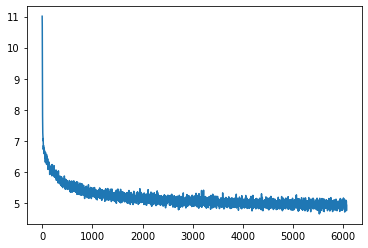

In [169]:
learn.recorder.plot_loss()

## Export

In [170]:
!python notebook2script.py 12a_awd_lstm.ipynb

Converted 12a_awd_lstm.ipynb to exp/nb_12a.py
